<a href="https://colab.research.google.com/github/csalguero10/InfoVisualization/blob/main/2024-2025/tutorials/data_analysis_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analysis

Case studies:

 * (geo-spatial analysis) female portraits distribution, from the Zeri photo archive and Wikidata.
 * (topical analysis) artistic periods studied by art historians, from ARTchives

## Geo-spatial analysis

**Research question**: where are female portraits preserved nowadays?

In [2]:
!pip install SPARQLWrapper folium pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 27.7 MB/s eta 0:00:00


In [ ]:
# Install necessary packages
!pip install SPARQLWrapper folium pandas numpy

# Import required libraries
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import folium
import numpy as np
from IPython.display import display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 13.4 MB/s eta 0:00:00


### Get the data

We perform a SPARQL query to retrieve relevant artworks, their location, and their coordinates.

 * We query the Federico Zeri photo archive for artworks that have as subject female portrait (i.e. the individual `<https://w3id.org/zericatalog/subject/ritratto-femminile>`).
 * We ask for the current `?keeper` of the artworks.
 * We filter `?location` _only if_ the latter is aligned to an entity in Wikidata (`?location owl:sameAs ?wdlocation. FILTER(contains (str(?wdlocation), "wikidata") )`) - Wikidata has the geolocation information, the Zeri archive does not!
 * We perform a Federated SPARQL query to Wikidata and we ask for the coordinates in a standard format (longitude and latitude)

We use SPARQLWrapper to sownload the data as JSON and we transform the JSON results into a dataframe.



In [ ]:
endpoint = "http://data.fondazionezeri.unibo.it/sparql"

# query female portraits and their location in Wikidata
q = """
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX fabio: <http://purl.org/spar/fabio/>
PREFIX frbr: <http://purl.org/vocab/frbr/core#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX psv: <http://www.wikidata.org/prop/statement/value/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>

SELECT DISTINCT ?artwork ?keeper ?keeperLabel ?coordinates WHERE {
  ?s fabio:hasSubjectTerm <https://w3id.org/zericatalog/subject/ritratto-femminile> ;
     fabio:hasManifestation ?manif .
  ?manif frbr:exemplar ?item .

  ?item crm:P50_has_current_keeper ?keeper ; rdfs:label ?artwork.

  ?keeper crm:P74_has_current_or_former_residence ?location .
  OPTIONAL {?keeper rdfs:label ?keeperLabel}
  ?location owl:sameAs ?wdlocation .
  FILTER(LANG(?artwork) = "" || LANGMATCHES(LANG(?artwork), "en"))
  FILTER(LANG(?keeperLabel) = "" || LANGMATCHES(LANG(?keeperLabel), "en"))
  FILTER(contains (str(?wdlocation), "wikidata") )

  SERVICE <https://query.wikidata.org/bigdata/namespace/wdq/sparql> {
    OPTIONAL {
    ?wdlocation wdt:P625 ?coordinates.  # Geo-coordinates
    }
  }
}

"""

# Run the query
sparql = SPARQLWrapper(endpoint)
sparql.setQuery(q)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
print(results)

HTTPError: HTTP Error 504: Gateway Time-out

### Prepare the data

In order to plot a map we need to **provide coordinates in a standard format** according to a projection system. Depending on the library we use, the format may vary (some libraries accept more formats).

Many web applications use the Mercator system, while the coordinates stored in Wikidata use another system (the one used by GPS). However, the property `wdt:P625` returns geo coordinates almost ready to be used on the web. We split the string to retrieve lat and long, and we sort them.

We store processed results in a dataframe.

In [ ]:
# Process results into a DataFrame
data = []
for item in results["results"]["bindings"]:
    try:
        portrait = item["artwork"]["value"]
        location = item["keeperLabel"]["value"] if "keeperLabel" in item else "Unknown"

        # Extract and clean coordinates
        if "coordinates" in item:
            coord_str = item["coordinates"]["value"].replace("Point(", "").replace(")", "")
            lon, lat = map(float, coord_str.split())  # Wikidata stores as "Point(LONG LAT)"
            data.append([portrait, location, lat, lon])  # Correct order: (lat, lon)
    except Exception as e:
        print(f"Skipping entry due to error: {e}")

# Create DataFrame
df = pd.DataFrame(data, columns=["Portrait", "Location", "Latitude", "Longitude"])

# Debugging: Check how many valid coordinates were extracted
print(f"Total valid locations extracted: {len(df)} / {len(results['results']['bindings'])}")

df.head()

Total valid locations extracted: 85 / 85


,Portrait,Location,Latitude,Longitude
0,"Artwork ""Anonimo fiorentino sec. XVI , Ritratt...",Asta Christie's,51.507222,-0.127500
1,"Artwork ""Ezechia da Vezzano , Ritratto femmini...",Asta Christie's,51.507222,-0.127500
2,"Artwork ""Tamagni Vincenzo , Ritratto femminile...",Asta Christie's,51.507222,-0.127500
3,"Artwork ""Foschi Pier Francesco , Ritratto femm...",Asta Christie's,51.507222,-0.127500
4,"Artwork ""Anonimo lombardo sec. XVI , Ritratto ...","Palazzo Pitti, Galleria Palatina e Appartament...",43.771389,11.254167


### Plot the data
We use `Folium` to plot our geographical map.

We setup the map.
 * the center as the median of all coordinates
 * the zoom level
 * the tile provider

To show multiple data points in the same place, we plot a bubble chart on top of the map.

 * We group points by coordinates
 * we set the radius of the bubble as the number of artworks in that location.
 * we design the content and the dimension of the popup

Lastly, we fill the map with our data and parameters. Every item of our dataframe becames an onject of type `CircleMarker`, which requires:
 * list of coordinates
 * color, transparency, and size of bubbles
 * popup content

We plot the map in the notebook and we save it as html too.

In [ ]:
# Ensure there are valid coordinates before mapping
if df.empty:
    print("No valid data found for mapping.")
else:
    # Center map around the average location
    map_center = [df["Latitude"].mean(), df["Longitude"].mean()]
    m = folium.Map(location=map_center, zoom_start=3, tiles="CartoDB positron")

    # Group by location to handle multiple portraits per location
    grouped = df.groupby(["Latitude", "Longitude"])

    for (lat, lon), group in grouped:
        count = len(group)  # Number of portraits at this location

        # Create a popup with all portrait names at this location

        popup_content = f"""
        <div style="width:250px; height:150px; overflow-y:auto;">
            <b>Paintings at this location({str(count)}):</b><br>
            {"<br>".join(group['Portrait'].tolist())}
        </div>
        """
        popup = folium.Popup(popup_content, max_width=300)  # Set max width

        # Create a circle marker
        folium.CircleMarker(
            location=[lat, lon],
            radius=5 + count,  # Larger circles for more paintings
            color="blue",
            fill=True,
            fill_color="blue",
            fill_opacity=0.6,
            popup=popup,
        ).add_to(m)

    # Save and display map correctly in Colab
    m.save("map.html")
    display(m)
    from google.colab import output
    output.eval_js('window.open("map.html")')  # Opens the map in a new tab

**Take home message**: most female portraits are currently preserved in Europe, mostly in Italy, with some outliers in the USA.

**Limitations**: the chart represents artworks (a) from Modern art only, (b) that were studied by Federico Zeri, and (c) that had a location aligned to Wikidata (~90 artworks). So results cannot be easily generalised.

**Interpretation**: so what? What does this map tell us? We can gather information from the map and from the literature to _either confirm facts, or to make new assumptions_.

1. We know from literature that _female nudes_ were a popular motif in Modern art

2. We know that female portraits, wherein women were depicted independently from their husbands, is a typical Florentine phenomenon (read [an thesis on this regard](https://www.proquest.com/docview/304372024?pq-origsite=gscholar&fromopenview=true))

3. All limitations considered, we can confirm that female portraits are a _european phenomenon_, which was popular in Italy between 15th and 16th century.

4. All limitations considered, _private collections_, followed by auction firms and the antiquarian market, seem to be the main owner of such type of artworks.

5. We can assume that this type of artworks were commissioned by privates, possibly for domestic display.


**What now?** the geographical analysis alone is not sufficient to draw conclusions, but it show new research directions.

 * we may analyse the provenance of artworks, so as to understand the trajectories of artworks, as well as provenance of artists, and confirm / make new assumptions on the commissioners (2, 3, 4)

 * we may analyse co-occurring subjects to identify artistic movements based on subjects (2)

 * we can speculate on motivations for commissioning such artworks (1, 4, 5)

### From Wikidata only

Let's quickly try the same query using Wikidata data only.

In [ ]:
# Install necessary packages
!pip install SPARQLWrapper folium pandas numpy

# Import required libraries
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import folium
import numpy as np
from IPython.display import display

# SPARQL endpoint and query
endpoint_url = "https://query.wikidata.org/sparql"

query = """
SELECT ?portrait ?portraitLabel ?location ?locationLabel ?coordinates
WHERE {
  ?portrait wdt:P31 wd:Q134307;  # Instance of: painting
           wdt:P136 wd:Q134307;  # Genre: portrait
           wdt:P180 ?depictedPerson.  # Depicts: someone

  ?depictedPerson wdt:P21 wd:Q6581072.  # Gender: female

  OPTIONAL {
    ?portrait wdt:P276 ?location.  # Location
    ?location wdt:P625 ?coordinates.  # Geo-coordinates
  }

  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
LIMIT 100
"""

# Run the query
sparql = SPARQLWrapper(endpoint_url)
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
# Set a custom User-Agent header
sparql.addCustomHttpHeader('User-Agent', 'MyBot/1.0 (your_email@example.com)') # Replace with your information
results = sparql.query().convert()

# Process results into a DataFrame
data = []
for item in results["results"]["bindings"]:
    try:
        portrait = item["portraitLabel"]["value"]
        location = item["locationLabel"]["value"] if "locationLabel" in item else "Unknown"

        # Extract and clean coordinates
        if "coordinates" in item:
            coord_str = item["coordinates"]["value"].replace("Point(", "").replace(")", "")
            lon, lat = map(float, coord_str.split())  # Wikidata stores as "Point(LONG LAT)"
            data.append([portrait, location, lat, lon])  # Correct order: (lat, lon)
    except Exception as e:
        print(f"Skipping entry due to error: {e}")

# Create DataFrame
df = pd.DataFrame(data, columns=["Portrait", "Location", "Latitude", "Longitude"])

# Debugging: Check how many valid coordinates were extracted
print(f"Total valid locations extracted: {len(df)} / {len(results['results']['bindings'])}")

# Ensure there are valid coordinates before mapping
if df.empty:
    print("No valid data found for mapping.")
else:
    # Center map around the average location
    map_center = [df["Latitude"].mean(), df["Longitude"].mean()]
    m = folium.Map(location=map_center, zoom_start=3, tiles="CartoDB positron")

    # Group by location to handle multiple portraits per location
    grouped = df.groupby(["Latitude", "Longitude"])

    for (lat, lon), group in grouped:
        count = len(group)  # Number of portraits at this location

        # Create a popup with all portrait names at this location
        popup_content = "<b>Paintings at this location:</b> "+str(count)+"<br>"
        popup_content += "<br>".join(group["Portrait"].tolist())

        # Create a circle marker
        folium.CircleMarker(
            location=[lat, lon],
            radius=5 + count,  # Larger circles for more paintings
            color="blue",
            fill=True,
            fill_color="blue",
            fill_opacity=0.6,
            popup=popup_content,
        ).add_to(m)

    # Save and display map correctly in Colab
    m.save("map.html")
    display(m)
    from google.colab import output
    output.eval_js('window.open("map.html")')  # Opens the map in a new tab


Total valid locations extracted: 14 / 14


As you can see results are pretty much different:

 * they are far less data points
 * they have a very different distribution (although the larger distribution is still in Italy)
 * they give a totally different idea of the problem.



## Topical analysis

**Research question**: what are co-occurring artistic/historical periods studied by art historians according to ARTchives?

### Get the data

We get our data from the data source on github.

In [ ]:
import rdflib
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS

# bind the uncommon namespaces
wd = Namespace("http://www.wikidata.org/entity/") # remember that a prefix matches a URI until the last slash (or hashtag #)
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")

# create an empty Graph
g = rdflib.ConjunctiveGraph()

# parse a local RDF file by specifying the format
result = g.parse("https://raw.githubusercontent.com/marilenadaquino/information_visualization/main/2021-2022/resources/artchives.nq", format='nquads')

<ipython-input-43-4c55af42a456>:11: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  g = rdflib.ConjunctiveGraph()


### Prepare the data

We need to work on co-occurrence of periods that are subject of collections.

To compute association rules, we need **a list of lists**, wherein each list includes all periods addressed by *one collection*. Be aware that the lists will not have the same length.

To create our list of lists, we use RDFLib methods and we iterate over triples.

In [ ]:
colls_and_periods = []

# get all the collections
for coll,isA,coll_class in g.triples(( None, RDF.type , wd.Q9388534)):
    # create a list for each collection
    coll_list = []
    # get all the periods for that collection
    for this_coll, hasSubj, period in g.triples(( coll, art.hasSubjectPeriod, None)):
        # get the labels of the periods
        for this_period, hasLabel, period_label in g.triples((period , RDFS.label, None )):
            # get only the last label
            period_label = str(period_label).strip()
        # append periods to the related collection
        coll_list.append(period_label)
    # append collections to the initial list
    colls_and_periods.append(coll_list)

print(colls_and_periods)

[['Renaissance', '15th century', '14th century', '16th century'], ['Baroque', '17th century', 'Renaissance', '15th century', 'Middle Ages', 'mannerism', '16th century'], ['Baroque', '17th century', 'Renaissance', '15th century', '16th century', 'neoclassicism', '18th century'], ['Cold War'], ['Renaissance'], ['17th century', '16th century'], ['Renaissance', '15th century'], ['Baroque', 'Renaissance', 'early Christian art and architecture', 'Byzantine art'], [], [], ['Baroque', '17th century', 'Renaissance', '16th century'], ['Renaissance', 'Middle Ages'], ['Renaissance'], ['Baroque', 'Middle Ages', 'mannerism', '16th century'], ['Baroque', '17th century', 'Renaissance', '15th century', 'mannerism', '16th century'], ['15th century', '16th century'], ['Baroque', '17th century', 'Renaissance', '15th century', 'mannerism', '16th century'], ['Baroque', '17th century', '18th century'], ['Middle Ages', 'early Christian art and architecture', 'Byzantine art'], ['Renaissance'], ['Baroque', 'man

Now that we have our list of lists we use methods from a library called **mlxtend** to compute the frequent itemsets (i.e. the frequent co-occurring periods). The **apriori** algorithm is used and returns a table with two columns, namely:

 * itemsets, the co-occurring items (or independent items)
 * their support, normalised between 0 and 1, indicating the frequency of the co-occurrence in the dataset.

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

dataset = colls_and_periods

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df, min_support=0.2, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.32,(15th century)
1,0.40,(16th century)
2,0.32,(17th century)
3,0.36,(Baroque)
4,0.20,(Middle Ages)
5,0.60,(Renaissance)
6,0.20,(mannerism)
7,0.28,"(15th century, 16th century)"
8,0.20,"(15th century, 17th century)"
9,0.28,"(15th century, Renaissance)"


The dataset is quite small and diverse, hence the co-occurrences do not have high support, meaning that the variables we are investigating **may be** independent from each other.

However, support is not the only metric of interest. The method `association_rules` allows us to specify another metric of interest and the threshold. The library supports **confidence** and **lift** (See more [here](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/)).

For instance, let's have a look at the itemsets that have high confidence, regardless of their support. That is, let's see which are the rules where the probability of seeing the consequent in a transaction (given a certain antecedent) is almost sure (0.8 out of 1).

In [ ]:
from mlxtend.frequent_patterns import association_rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)
rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,15th century,16th century,0.32,0.40,0.28,0.875000,2.187500,1.0,0.1520,4.80,0.798319,0.636364,0.791667,0.787500
1,15th century,Renaissance,0.32,0.60,0.28,0.875000,1.458333,1.0,0.0880,3.20,0.462185,0.437500,0.687500,0.670833
2,17th century,16th century,0.32,0.40,0.28,0.875000,2.187500,1.0,0.1520,4.80,0.798319,0.636364,0.791667,0.787500
3,mannerism,Baroque,0.20,0.36,0.20,1.000000,2.777778,1.0,0.1280,inf,0.800000,0.555556,1.000000,0.777778
4,15th century,16th century,0.20,0.40,0.20,1.000000,2.500000,1.0,0.1200,inf,0.750000,0.500000,1.000000,0.750000
5,15th century,Renaissance,0.28,0.60,0.24,0.857143,1.428571,1.0,0.0720,2.80,0.416667,0.375000,0.642857,0.628571
6,15th century,16th century,0.28,0.40,0.24,0.857143,2.142857,1.0,0.1280,4.20,0.740741,0.545455,0.761905,0.728571
7,16th century,15th century,0.28,0.32,0.24,0.857143,2.678571,1.0,0.1504,4.76,0.870370,0.666667,0.789916,0.803571
8,15th century,Renaissance,0.20,0.60,0.20,1.000000,1.666667,1.0,0.0800,inf,0.500000,0.333333,1.000000,0.666667
9,Renaissance,15th century,0.24,0.32,0.20,0.833333,2.604167,1.0,0.1232,4.08,0.810526,0.555556,0.754902,0.729167


Since we selected a very high threshold, we see that most rules have a high confidence (`1.0`), despite a medium/low support (we have few and diverse data), high lift (how much often antec and conseq appear together, the higher the more these are dependent), and high conviction (`inf` means that the consequent is highly depending on the antecedent).

### Plot the data

We use `networkx` to plot a network graph where to check relations between antecedents and consequents obtained via an association rule.

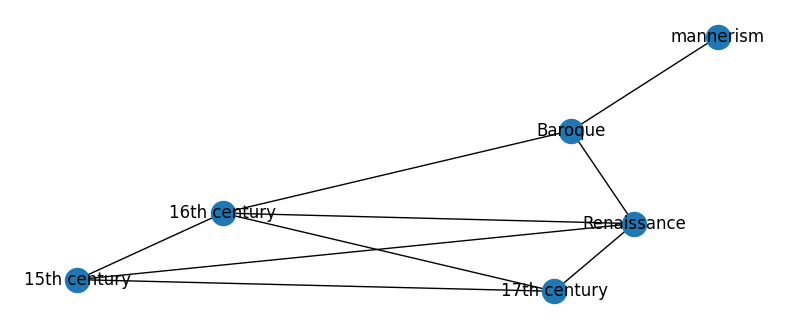

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
fig, ax=plt.subplots(figsize=(10,4))
GA=nx.from_pandas_edgelist(rules,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True)
plt.show()



From the results we get some interesting insights. For instance, it seems very likely that mannerism and baroque are studied together. Similarly, if a collection addresses 15th century and 17th century, it's very likely that it will also address Renaissance and 16th century.

### Why is this interesting?

Assume that *cataloguers of ARTchives did not enter data with the same effort* for every collections. Some collections may be more accurately annotated, while others might include just a few topics.

We can quantify the probability to find certain topics that are not explictly stated by cataloguers and we can recommend collections to historians according to the relevance of these probabilities. For instance, if a user is looking for collections relevant to *Baroque*, we may rank collections, showing first the ones that address for sure the searched term, and secondly the ones that are *more likely* to address it, i.e. those addressing *Mannerism*.

## Exercise / Homework

Apply the apriori algorithm to calculate which people (`art:hasSubjectPerson`) mostly co-occur in ARTchives collections. Write the three rules with the highest confidence in the form: (antecedents) - (consequents).
Fill in the [questionnaire](https://forms.gle/cri2JhzGTzGzofZu7) with the answer!